# Gather Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt

data = pd.read_csv('C:/Users/Drew/Downloads/widget_sales.csv')
data.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [3]:
data.describe()

,widget_sales
count,500.000000
mean,46.969858
std,15.382473
min,20.674946
25%,32.507149
50%,47.667536
75%,59.425693
max,82.922496


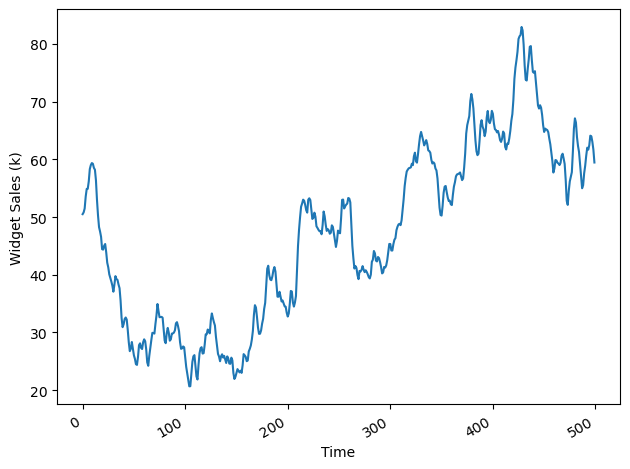

In [4]:
fig, ax = pt.subplots()

ax.plot(data['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales (k)')
fig.autofmt_xdate()
pt.tight_layout()

In [5]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(data['widget_sales'])
print(f' ADF Statistic: {ADF_result[0]}')
print(f' P-value: {ADF_result[1]}')

 ADF Statistic: -1.512166206935896
 P-value: 0.5274845352272648


Data is not stationary, so we have to perform transformation to make the data stationary

In [6]:
widget_diff = np.diff(data['widget_sales'], n=1)

In [7]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(widget_diff)
print(f' ADF Statistic: {ADF_result[0]}')
print(f' P-value: {ADF_result[1]}')

 ADF Statistic: -10.576657780341957
 P-value: 7.076922818587346e-19


Now the data is stationary. We can list values of p and q now since we are not using the ACF approach to identify the order. We are using the general modeling procedure from the ARMA process.

In [8]:
#Function to fit all unique ARMA(p,q) models
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    #Initialize an empty list to store the order (p,q) and its corresponding AIC as a tuple
    results = [] 
    
    #Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar.
    for order in tqdm(order_list): 
        try:
            #simple_differencing = False to prevent differencing
            #disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], 0, order[1]),
                            simple_differencing = False).fit(disp=False)
        except:
            continue
        
        aic = model.aic #Calculate the model's AIC
        results.append([order,aic]) #Append the (p,q) combination and AIC as a tuple to result list
    
    result_data = pd.DataFrame(results) #Store the combination in a DataFrame
    result_data.columns = ['(p,q)', 'AIC'] #Label the columns of the DataFrame
    
    #Sort in ascending order, lower AIC is better
    result_data = result_data.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_data

In [9]:
from itertools import product

ps = range(0,4,1) #Create a list of possible values for p starting from 0 inclusively to 4 exclusively, with steps of 1
qs = range(0,4,1) #Create a list of possible values of q starting from 0 inclusively to 4 exclusively, with steps of 1


order_list = list(product(ps, qs))

In [10]:
data_diff = pd.DataFrame({'widget_diff': widget_diff})

train = data_diff[:-100]
test = data_diff[-100:]

print(len(train))
print(len(test))

399
100


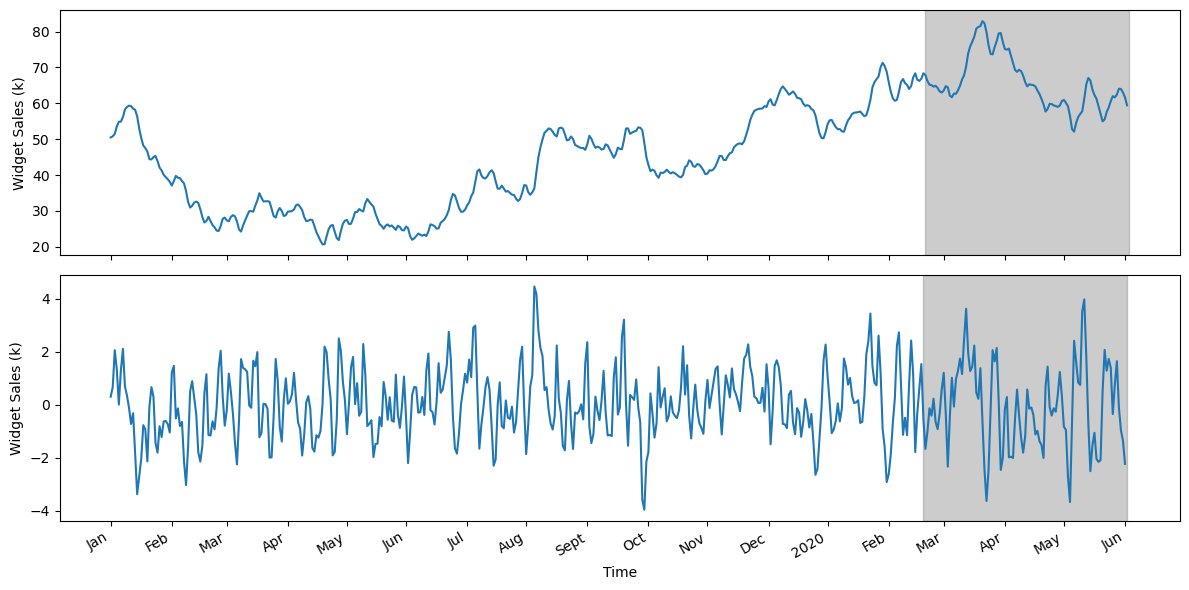

In [11]:
fig, (ax1, ax2) = pt.subplots(nrows=2, ncols=1, sharex=True,figsize=(12,6))

ax1.plot(data['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget Sales (k)')
ax1.axvspan(400, 500, color="#808080", alpha=0.4)

ax2.plot(data_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget Sales (k)')
ax2.axvspan(399, 499, color="#808080", alpha=0.4)

pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])

fig.autofmt_xdate()
pt.tight_layout()

In [12]:
result_data = optimize_ARMA(train['widget_diff'], order_list)
result_data

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(0, 2)",1104.800280
1,"(2, 1)",1105.428379
2,"(1, 1)",1106.095730
3,"(0, 3)",1106.347957
4,"(1, 2)",1106.484821
5,"(3, 0)",1106.798080
6,"(3, 1)",1106.949915
7,"(2, 2)",1107.203047
8,"(2, 3)",1107.330995
9,"(3, 3)",1107.772406


In [13]:
model = SARIMAX(train['widget_diff'], order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

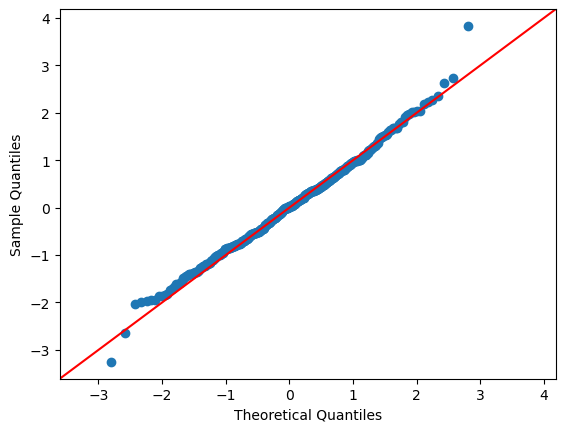

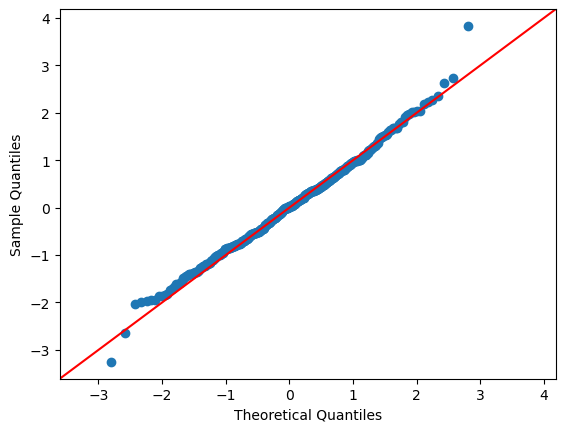

In [14]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45')

In [15]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            widget_diff   No. Observations:                  399
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -550.048
Date:                Sun, 28 Apr 2024   AIC                           1106.096
Time:                        06:11:35   BIC                           1118.063
Sample:                             0   HQIC                          1110.835
                                - 399                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3071      0.071      4.334      0.000       0.168       0.446
ma.L1          0.5368      0.062      8.725      0.000       0.416       0.657
sigma2         0.9207      0.059     15.476      0.0

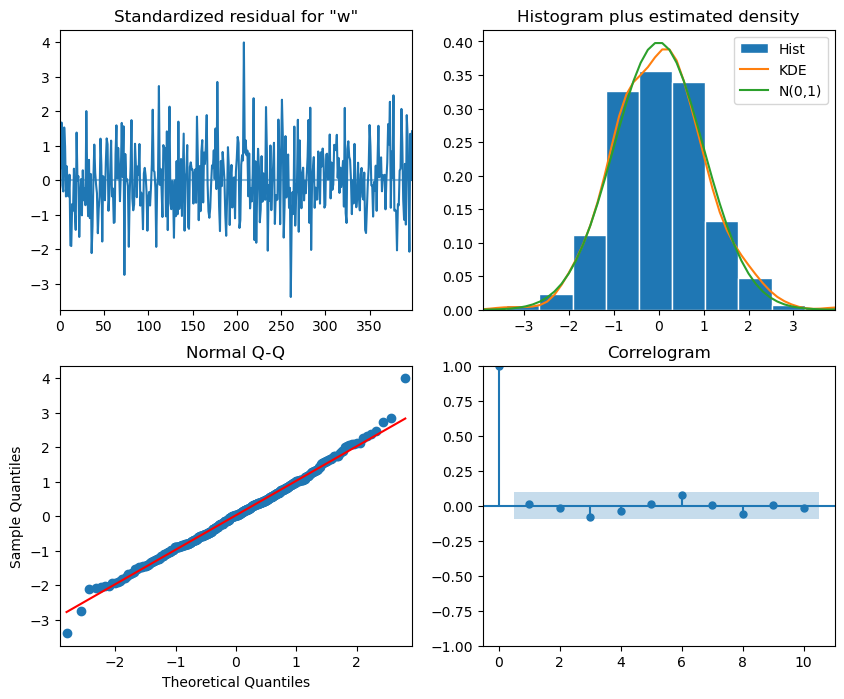

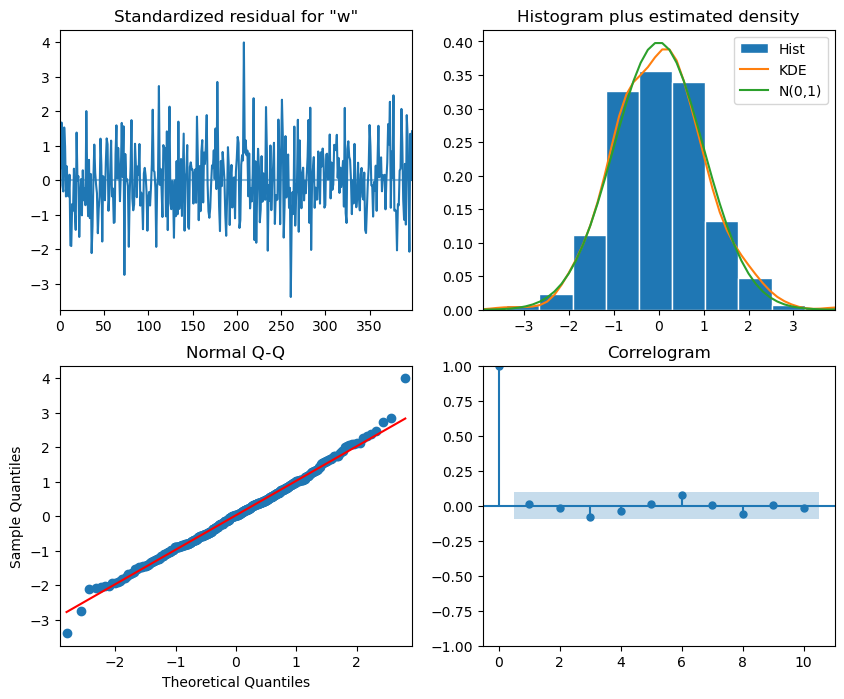

In [16]:
model_fit.plot_diagnostics(figsize=(10,8))

The residual analysis all looks fine. The standardized residuals are stationary indicating it is evenly distributed. The histogram showed normal distribution curve which also indicates that the residuals are evenly distributed. The Q-Q plot showed a straight line on the y=x line. Correlogram is not significant after lag 0 which indicates that the coefficients are uncorrelated.

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

     lb_stat  lb_pvalue
1   0.081029   0.775907
2   0.148394   0.928489
3   2.957987   0.398148
4   3.618690   0.460062
5   3.677878   0.596660
6   6.212089   0.399856
7   6.239041   0.512132
8   7.586895   0.474826
9   7.604496   0.574441
10  7.747054   0.653529


P-value for all 10 lags are more than 0.05. Thus we cannot reject the null hypothesis and conclude that the residuals are uncorrelated and normally distributed. 

# Forecasting

In [18]:
#The function takes in a DataFrame containing the full simulated moving average process. 
#Train_len: have to pass in the length of training set
#Horizon: have to pass in the length of test set
#Window: How many timesteps we want to predict
#Method: the method we are using
def rolling_forecast(data: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

    elif method == 'ARMA':
        pred_ARMA= []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [19]:
pred_data = test.copy()

TRAIN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_MA = rolling_forecast(data_diff, TRAIN, HORIZON, WINDOW, 'MA')
pred_AR = rolling_forecast(data_diff, TRAIN, HORIZON, WINDOW, 'AR')
pred_ARMA = rolling_forecast(data_diff, TRAIN, HORIZON, WINDOW, 'ARMA')

pred_data['pred_MA'] = pred_MA
pred_data['pred_AR'] = pred_AR
pred_data['pred_ARMA'] = pred_ARMA

In [20]:
pred_data.head()

,widget_diff,pred_MA,pred_AR,pred_ARMA
399,-0.514755,1.080784,1.032494,1.203222
400,-1.663015,0.304014,0.286820,0.369464
401,-1.012522,-0.902671,-1.153223,-0.822149
402,-0.128113,-0.147446,-0.335515,-0.250077
403,-0.406210,0.068265,0.257076,0.111156


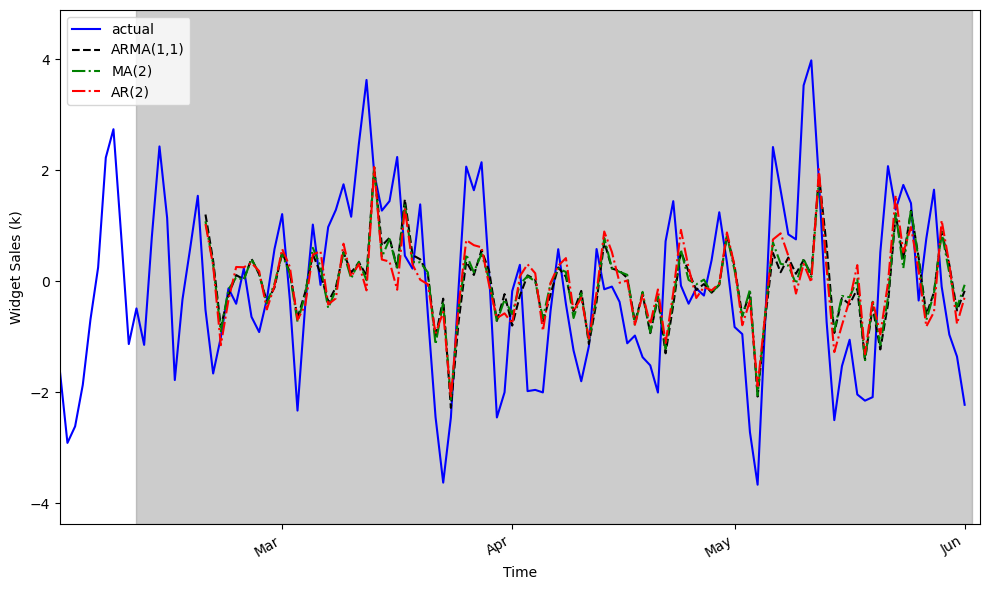

In [21]:
fig, ax = pt.subplots(figsize=(10,6))

ax.plot(data_diff['widget_diff'], 'b-', label='actual')
ax.plot(pred_data['pred_ARMA'], 'k--', label='ARMA(1,1)')
ax.plot(pred_data['pred_MA'], 'g-.', label='MA(2)')
ax.plot(pred_data['pred_AR'], 'r-.', label='AR(2)')
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales (k)')
ax.legend(loc=2)
ax.axvspan(390, 499, color="#808080", alpha=0.4)
ax.set_xlim(380,500)
pt.xticks([409, 439, 468, 498],
          ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
pt.tight_layout()

In [22]:
from sklearn.metrics import mean_squared_error

mse_MA = mean_squared_error(pred_data['widget_diff'], pred_data['pred_MA'])
mse_AR = mean_squared_error(pred_data['widget_diff'], pred_data['pred_AR'])
mse_ARMA = mean_squared_error(pred_data['widget_diff'], pred_data['pred_ARMA'])

print("The MSE of MA is: ",mse_MA)
print("The MSE of AR is: ", mse_AR)
print("The MSE of ARMA is: ", mse_ARMA)

The MSE of MA is:  1.8221984650770295
The MSE of AR is:  1.8280233400902128
The MSE of ARMA is:  1.8403467673439484


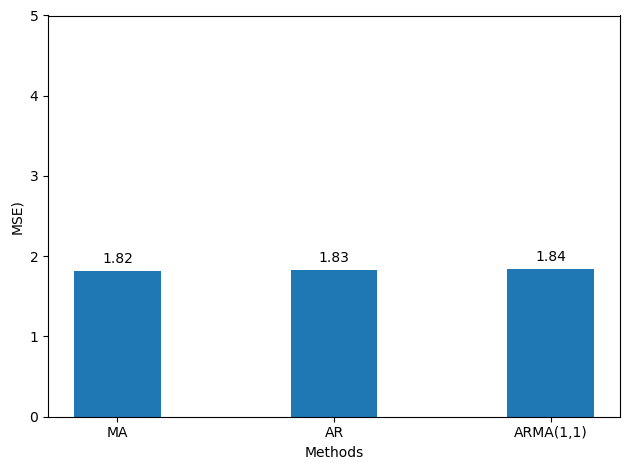

In [23]:
fig, ax = pt.subplots()

x = ['MA', 'AR', 'ARMA(1,1)']
y = [1.82, 1.83, 1.84]

#Histogram
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE)')
ax.set_ylim(0, 5)

for index, value in enumerate(y): #Display the value on top of the bar 
    pt.text(x=index, y=value + 0.1, s=str(value), ha='center') #y= value + 1 is to position the text slightly above the bar so it does not overlap

pt.tight_layout()

In [24]:
data['pred_widget_sales'] = pd.Series() #Initialize an empty column to hold our predictions
data['pred_widget_sales_MA'] = pd.Series()
#Inverse transform the predictions to bring them back to the original scale of the dataset
data['pred_widget_sales'][400:] = data['widget_sales'].iloc[400] + pred_data['pred_ARMA'].cumsum() 
data['pred_widget_sales_MA'][400:] = data['widget_sales'].iloc[400] + pred_data['pred_MA'].cumsum() 

C:\Users\Drew\AppData\Local\Temp\ipykernel_29832\3735664890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_widget_sales'][400:] = data['widget_sales'].iloc[400] + pred_data['pred_ARMA'].cumsum()
C:\Users\Drew\AppData\Local\Temp\ipykernel_29832\3735664890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_widget_sales_MA'][400:] = data['widget_sales'].iloc[400] + pred_data['pred_MA'].cumsum()


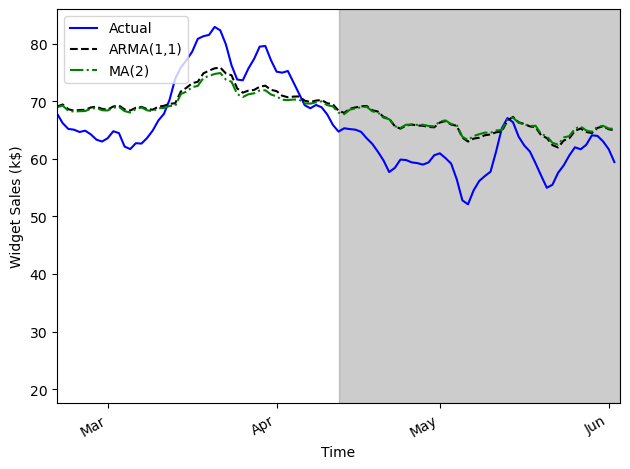

In [27]:
fig, ax = pt.subplots()

ax.plot(data['widget_sales'], 'b-', label='Actual')
ax.plot(data['pred_widget_sales'], 'k--', label='ARMA(1,1)')
ax.plot(data['pred_widget_sales_MA'], 'g-.', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales (k$)')
ax.axvspan(450, 500, color="#808080", alpha=0.4)
ax.set_xlim(400,500)
pt.xticks([409, 439, 468, 498],
          ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
pt.tight_layout()

In [28]:
from sklearn.metrics import mean_absolute_error

mae_ARMA_undiff = mean_absolute_error(data['widget_sales'].iloc[400:], 
                                    data['pred_widget_sales'].iloc[400:])
mae_MA_undiff = mean_absolute_error(data['widget_sales'].iloc[400:], 
                                    data['pred_widget_sales_MA'].iloc[400:])
print("The MAE of ARMA is: ", mae_ARMA_undiff)
print("The MAE of MA is: ", mae_MA_undiff)

The MAE of ARMA is:  4.640918929304061
The MAE of MA is:  4.811326708177521
